# Memory      
- Memory can be broken down into 2 kinds
    1. Short-term Memory     
    2. Long-term Memory

## Short-term Memory        
* Langchain allows to store conversation history in memory (RAM).           
* It is recommended to use Postgress saver instead of InMemorySaver for production.
* Important Concepts - 
    1. Super Step 
        - Every sequntial node in a graph is considered as a super step.                    
        - Parallel nodes are considered to be a single super step.
    2. Checkpoint
        - State and relavent metadata at a **super step** is a checkpoint.
    3. Thread           
        - Thread is used to differentiate one conversation to another.       
        - Checkpoints are stored under a **thread** so data realavent to a paticular conversation can be differentiated.


In [ ]:
import os
from dotenv import load_dotenv

from langchain_openai.chat_models import ChatOpenAI
from langchain_core.messages import BaseMessage, SystemMessage, HumanMessage
from langchain_core.tools import tool

from langgraph.graph.message import add_messages
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import InMemorySaver
from langgraph.prebuilt import ToolNode

from typing import TypedDict, List, Annotated

from IPython.display import Image, display

In [15]:
OPENAI_API_KEY = os.getenv('OPENAI_API_KEY')
LANGSMITH_API_KEY = os.getenv('LANGSMITH_API_KEY')

os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_ENDPOINT"] = "https://api.smith.langchain.com"
os.environ["LANGSMITH_API_KEY"] = LANGSMITH_API_KEY
os.environ["LANGSMITH_PROJECT"] = "pr-respectful-recapitulation-78"

load_dotenv()

True

In [14]:
class AgentState(TypedDict):
    query : str
    messages : Annotated[List[BaseMessage], add_messages]

checkpointer = InMemorySaver()

In [32]:
#tools
@tool
def add(a:float, b:float)->float:
    """This is a addition function that can be used to add two floting point numbers"""
    return a + b

@tool
def sub(a:float, b:float)->float:
    """This is a subtraction function that can be used to subtract two floting point numbers"""
    return a - b

@tool
def mult(a:float, b:float)->float:
    """This is a multiplication function that can be used to multiply two floting point numbers"""
    return a * b

@tool
def divide(a:float, b:float)->float:
    """This is a division function that can be used to divide two floting point numbers"""
    return a / b

tools = [add, sub, mult, divide]

In [33]:
#llm
llm = ChatOpenAI(model="o3-mini-2025-01-31").bind_tools(tools)

In [35]:
llm.invoke("What is the addition of 10 and 12.5")

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_1MTsDwQ0QdAsbEmajLerN9v9', 'function': {'arguments': '{"a": 10, "b": 12.5}', 'name': 'add'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 100, 'prompt_tokens': 171, 'total_tokens': 271, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 64, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'o3-mini-2025-01-31', 'system_fingerprint': None, 'id': 'chatcmpl-BtWmXbFXDfhdsNUzO7sATeWTY3W8y', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--93d43d1e-249d-484d-b6e4-85c5f3c87f4d-0', tool_calls=[{'name': 'add', 'args': {'a': 10, 'b': 12.5}, 'id': 'call_1MTsDwQ0QdAsbEmajLerN9v9', 'type': 'tool_call'}], usage_metadata={'input_tokens': 171, 'output_tokens': 100, 'total_tokens': 271, 'input_token_details': {'audio': 0, 'cache_read'

In [42]:
#nodes
def setup_node(state:AgentState)->AgentState:
    system_prompt_str = """
- You are a helpful assistant who helps kids perform multi-stage calculations.
- Break down complex problems into simple, easy-to-follow steps.
- Always use the provided tools for arithmatic calculations.
- Output the final response explaining each step"""
    state['messages'] = [SystemMessage(system_prompt_str),
                         HumanMessage(f"{state['query']}")]
    return state

def agent_node(state:AgentState)->AgentState:
    response = llm.invoke(state['messages'])
    state['messages'] = response
    return state

tool_node = ToolNode(tools)

In [43]:
#condition edges
def router(state:AgentState)->AgentState:
    last_message = state['messages'][-1]
    tool_calls = last_message.tool_calls
    if tool_calls:
        return 'tools call'
    else:
        return 'exit'

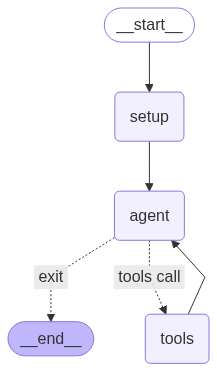

In [44]:
workflow = StateGraph(AgentState)

#nodes
workflow.add_node('setup',setup_node)
workflow.add_node('agent',agent_node)
workflow.add_node('tools',tool_node)

#edges
workflow.add_edge(START, 'setup')
workflow.add_edge('setup', 'agent')
workflow.add_edge('tools', 'agent')

#conditional edges
workflow.add_conditional_edges(source='agent',
                               path=router,
                               path_map={
                                   'tools call' : 'tools',
                                   'exit' : END
                               })

graph = workflow.compile(checkpointer=checkpointer)

display(Image(graph.get_graph().draw_mermaid_png()))

In [45]:
query = "James have 10 apples and 5 oranges, then George takes 2 apples and 1 orange how many apples and oranges does James have now?"
config = {"configurable": {"thread_id": "2"}}
response = graph.stream({'query': query, 'messages':[]}, stream_mode='values', config=config)
for res in response:
    message = res['messages'][-1] if res['messages'] else ()
    if isinstance(message, tuple):
        print(message)
    else:
        message.pretty_print()

================================== Ai Message ==================================

Step 1: Recall from the previous calculation that James has 8 apples and 4 oranges, and George (who took fruit from James earlier) has 2 apples and 1 orange.

Step 2: George gives all the apples he has (2 apples) to Cleetus. This means George now has 0 apples (2 - 2 = 0) and still has his 1 orange.

Step 3: James gives 2 apples and 2 oranges to Cleetus. So, we need to update James’s counts:
• Apples: 8 - 2 = 6 apples  
• Oranges: 4 - 2 = 2 oranges

Step 4: Cleetus receives fruit from both George and James.  
• From George: 2 apples  
• From James: 2 apples and 2 oranges  
Thus, Cleetus now has a total of 2 + 2 = 4 apples and 2 oranges.

Final Answer:
• James now has 6 apples and 2 oranges.  
• George now has 0 apples and 1 orange.  
• Cleetus has 4 apples and 2 oranges.
================================ Human Message =================================

James have 10 apples and 5 oranges, then George takes 2

In [41]:
query = "Now George gives all of this apples to Cleetus and James gives 2 apples and 2 oranges to Cleetus. How many apples and orages does each of them have?"
config = {"configurable": {"thread_id": "2"}}
response = graph.stream({'query': query, 'messages':[]}, stream_mode='values', config=config)
for res in response:
    message = res['messages'][-1] if res['messages'] else ()
    if isinstance(message, tuple):
        print(message)
    else:
        message.pretty_print()

================================== Ai Message ==================================

Step 1: James initially has 10 apples and 5 oranges.

Step 2: George takes away 2 apples. So, to find out how many apples remain, we subtract 2 from 10. That gives 10 - 2 = 8 apples.

Step 3: George also takes away 1 orange. So, to find out how many oranges remain, we subtract 1 from 5. That gives 5 - 1 = 4 oranges.

Final Answer: James now has 8 apples and 4 oranges.
================================ Human Message =================================

Now George gives all of this apples to Cleetus and James gives 2 apples and 2 oranges to Cleetus. How many apples and orages does each of them have?
================================== Ai Message ==================================

Step 1: Recall from the previous calculation that James has 8 apples and 4 oranges, and George (who took fruit from James earlier) has 2 apples and 1 orange.

Step 2: George gives all the apples he has (2 apples) to Cleetus. This mean

#### Latest State

In [47]:
config = {"configurable": {"thread_id": "2"}}
history = graph.get_state(config)

In [48]:
history

StateSnapshot(values={'query': 'James have 10 apples and 5 oranges, then George takes 2 apples and 1 orange how many apples and oranges does James have now?', 'messages': [SystemMessage(content='\n- You are a helpful assistant who helps kids perform multi-stage calculations.\n- Break down complex problems into simple, easy-to-follow steps.\n- Always use the provided tools for calculations.\n- Output the final response explaining each step', additional_kwargs={}, response_metadata={}, id='f20290ab-708a-4109-8e21-569e1eccb0b7'), HumanMessage(content='James have 10 apples and 5 oranges, then George takes 2 apples and 1 orange how many apples and oranges does James have now?', additional_kwargs={}, response_metadata={}, id='2fdb3d79-d4c3-48a4-a45f-d397ed6dfa4b'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_ynD3UIq1HHOfZP5fiWz8LEfs', 'function': {'arguments': '{"a": 10, "b": 2}', 'name': 'sub'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage

#### Full State History

In [52]:
config = {"configurable": {"thread_id": "2"}}
list(graph.get_state_history(config))

[StateSnapshot(values={'query': 'James have 10 apples and 5 oranges, then George takes 2 apples and 1 orange how many apples and oranges does James have now?', 'messages': [SystemMessage(content='\n- You are a helpful assistant who helps kids perform multi-stage calculations.\n- Break down complex problems into simple, easy-to-follow steps.\n- Always use the provided tools for calculations.\n- Output the final response explaining each step', additional_kwargs={}, response_metadata={}, id='f20290ab-708a-4109-8e21-569e1eccb0b7'), HumanMessage(content='James have 10 apples and 5 oranges, then George takes 2 apples and 1 orange how many apples and oranges does James have now?', additional_kwargs={}, response_metadata={}, id='2fdb3d79-d4c3-48a4-a45f-d397ed6dfa4b'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_ynD3UIq1HHOfZP5fiWz8LEfs', 'function': {'arguments': '{"a": 10, "b": 2}', 'name': 'sub'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usag

#### New Thread

In [50]:
#new thread
query = "Cleetus buys 30 apples and gives 10 to George out of which he gives James 5. How many apples does each of them have?"
config = {"configurable": {"thread_id": "3"}}
response = graph.stream({'query': query, 'messages':[]}, stream_mode='values', config=config)
for res in response:
    message = res['messages'][-1] if res['messages'] else ()
    if isinstance(message, tuple):
        print(message)
    else:
        message.pretty_print()

()
================================ Human Message =================================

Cleetus buys 30 apples and gives 10 to George out of which he gives James 5. How many apples does each of them have?
================================== Ai Message ==================================
Tool Calls:
  sub (call_XCwQQkEbqADcfPRIpJZsXEVi)
 Call ID: call_XCwQQkEbqADcfPRIpJZsXEVi
  Args:
    a: 30
    b: 10
================================= Tool Message =================================
Name: sub

20.0
================================== Ai Message ==================================
Tool Calls:
  sub (call_mdkKZNDJfAWUI17l6GjcjEo8)
 Call ID: call_mdkKZNDJfAWUI17l6GjcjEo8
  Args:
    a: 10
    b: 5
================================= Tool Message =================================
Name: sub

5.0
================================== Ai Message ==================================

Let's break down the problem step by step:

1. Cleetus initially had 30 apples.
2. He gave 10 apples to George. To find out ho

## Long-term Memory          
* Long term memory is used to store that can be accsessed across threads.         
* It is not unique to a thread but can be made unique to a user.